In [1]:
"""
@author: Emna Rejaibi
"""
import numpy as np
from pathlib import Path
import csv, re, os
import matplotlib.pyplot as plt
import pandas as pd
# Pre-Processing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
# Keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.utils.np_utils import to_categorical 
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, History
from keras import regularizers
import keras.backend as K

import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def Load_Data():
    # Get Input and Target Data
    input_data = np.ones([1, 57])
    target_data_binary_PHQ = [0]
    target_data_score_PHQ = [0]
    
    i = 1
    target_data_csv = Path('D:/Emna/DAIC WOZ # EMNA/DAIC WOZ # EMNA/full_dataset.csv')
    with open(target_data_csv, 'r') as csvFile:
        reader = csv.reader(csvFile)
        for row in reader:
            try:
                participant_ID = str(re.split('\t', row[0])[0])
                binary_PHQ8 = int(re.split('\t', row[1])[0])
                score_PHQ8 = int(re.split('\t', row[2])[0])
                print(" ## \n Participant ID is:{}, with Binary PHQ:{} , and Score PHQ:{} : ", participant_ID, binary_PHQ8, score_PHQ8)
                
                csv_file_path ='D:/Emna/DAIC WOZ # EMNA/DAIC WOZ # EMNA/'+participant_ID+'_P/split/Participant/'
                if os.path.exists(csv_file_path):
                    input_directory = Path(csv_file_path)
                    for my_csv_filename in input_directory.glob("*_AUDIO_*.csv"):  
                        # Extract the .csv filename   
                        my_csv_filename = my_csv_filename.stem
                        print("## \n Retrieving coef matrix from file: ", my_csv_filename)

                        io = pd.read_csv(csv_file_path+my_csv_filename+'.csv', sep=",", usecols=(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,60))

                        # Get the Matrix
                        i = i+1
                        io = np.array(io, dtype=np.float32)
                        print("###################################################")
                        
                        input_data = np.append(input_data, io, axis=0)                       
                        for j in range(io.shape[0]):
                            target_data_binary_PHQ.append(binary_PHQ8)
                            target_data_score_PHQ.append(score_PHQ8)
                            
            except ValueError:
                print("Skipping the following line: ", row[0])
    csvFile.close()            
                
    print("the size of my list-input-matrix: ", i)
    
    input_data_final = np.delete(input_data, 0, 0)
    target_data_binary_PHQ_final = np.delete(target_data_binary_PHQ, 0, 0)
    target_data_score_PHQ_final = np.delete(target_data_score_PHQ, 0, 0)
    
    return input_data_final, target_data_binary_PHQ_final, target_data_score_PHQ_final

# Loading data
input_data, target_data_binary_PHQ, target_data_score_PHQ = Load_Data()




Using TensorFlow backend.


Skipping the following line:  Participant_ID
 ## 
 Participant ID is:{}, with Binary PHQ:{} , and Score PHQ:{} :  303 0 0
## 
 Retrieving coef matrix from file:  303_AUDIO_0
###################################################
## 
 Retrieving coef matrix from file:  303_AUDIO_1
###################################################
## 
 Retrieving coef matrix from file:  303_AUDIO_10
###################################################
## 
 Retrieving coef matrix from file:  303_AUDIO_100
###################################################
## 
 Retrieving coef matrix from file:  303_AUDIO_101
###################################################
## 
 Retrieving coef matrix from file:  303_AUDIO_102
###################################################
## 
 Retrieving coef matrix from file:  303_AUDIO_11
###################################################
## 
 Retrieving coef matrix from file:  303_AUDIO_12
###################################################
## 
 Retrieving coef matrix from file

In [42]:
target=pd.DataFrame(target_data_binary_PHQ)
target[0].value_counts()

0    1244458
1     510459
Name: 0, dtype: int64

In [39]:
input_data.shape

(1754917, 57)

In [ ]:
target=pd.DataFrame(input_data)
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
count,1.754917e+06,1.754917e+06,1.754917e+06,1.754917e+06,1.754917e+06,1.754917e+06,1.754917e+06,1.754917e+06,1.754917e+06,1.754917e+06,...,1.754917e+06,1.754917e+06,1.754917e+06,1.754917e+06,1.754917e+06,1.754917e+06,1.754917e+06,1.754917e+06,1.754917e+06,1.754917e+06
mean,-1.734554e+00,-8.971801e-01,-3.113454e-01,-7.972012e-01,-7.160500e-01,-7.519225e-01,-3.393633e-01,-3.092756e-01,-1.415970e-01,-2.844579e-01,...,1.840607e-02,1.900486e-02,5.466634e-02,4.864297e-02,5.067504e-02,4.171071e-02,3.437110e-02,3.157400e-02,4.088266e-02,3.970305e+01
std,2.945930e+00,1.761947e+00,1.395151e+00,1.069435e+00,9.908984e-01,8.361973e-01,7.222606e-01,6.570873e-01,6.331838e-01,5.349954e-01,...,7.253578e+00,6.939059e+00,6.310433e+00,5.859403e+00,5.669212e+00,5.101686e+00,4.689901e+00,4.509942e+00,4.323437e+00,1.735644e+01
min,-1.419003e+01,-9.499455e+00,-6.935476e+00,-6.881899e+00,-5.385520e+00,-4.911435e+00,-4.391728e+00,-3.928926e+00,-3.385232e+00,-3.165742e+00,...,-4.464558e+01,-4.510346e+01,-4.490970e+01,-4.112171e+01,-3.956762e+01,-4.084458e+01,-3.889404e+01,-3.480339e+01,-3.362213e+01,-1.765771e+02
25%,-3.405981e+00,-2.079444e+00,-1.206821e+00,-1.427502e+00,-1.336620e+00,-1.286275e+00,-7.965279e-01,-7.154126e-01,-5.447015e-01,-6.075200e-01,...,-4.493334e+00,-4.296274e+00,-3.885000e+00,-3.615869e+00,-3.472570e+00,-3.146296e+00,-2.863121e+00,-2.717474e+00,-2.561854e+00,3.710863e+01
50%,-1.063672e+00,-7.302984e-01,-3.704428e-01,-6.629988e-01,-5.913283e-01,-7.058944e-01,-2.806353e-01,-2.761382e-01,-1.190173e-01,-2.566861e-01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.096141e+01
75%,3.578043e-01,3.353546e-01,5.356329e-01,-7.275169e-02,-2.024677e-02,-1.975529e-01,1.438565e-01,1.059557e-01,2.537271e-01,5.260596e-02,...,4.511133e+00,4.286767e+00,3.883573e+00,3.637345e+00,3.540833e+00,3.204816e+00,2.918284e+00,2.778180e+00,2.627118e+00,4.465926e+01
max,9.122910e+00,6.566734e+00,6.519344e+00,3.439885e+00,3.935709e+00,3.560371e+00,3.570163e+00,3.043211e+00,3.108714e+00,2.750388e+00,...,4.574831e+01,3.986323e+01,4.591668e+01,5.063490e+01,3.946264e+01,4.468849e+01,3.999957e+01,4.370761e+01,4.606602e+01,6.853945e+01


In [ ]:
# Splitting into Training and Testing datasets
input_data = np.asarray(input_data, dtype=np.float32)
target_bin = np.asarray(target_data_binary_PHQ, dtype=int)
target_score = np.asarray(target_data_score_PHQ, dtype=np.int64)

#"Testing Binary Score"
x_train, x_validation, y_train, y_validation = train_test_split(input_data, target_bin, test_size = 0.2 , random_state = 42)

#"Testing PHQ scores"
#x_train, x_validation, y_train, y_validation = train_test_split(input_data, target_score, test_size = 0.2 , random_state = 42)

x_validation, x_test, y_validation, y_test = train_test_split(x_validation, y_validation, test_size = 0.4 , random_state = 42)

print("###split complete###")

scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_validation = scaler.transform(x_validation)
x_test = scaler.transform(x_test)
print("Done Scaling!")


###split complete###
Done Scaling!


In [ ]:
data=pd.DataFrame(x_train)
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
count,1.403933e+06,1.403933e+06,1.403933e+06,1.403933e+06,1.403933e+06,1.403933e+06,1.403933e+06,1.403933e+06,1.403933e+06,1.403933e+06,...,1.403933e+06,1.403933e+06,1.403933e+06,1.403933e+06,1.403933e+06,1.403933e+06,1.403933e+06,1.403933e+06,1.403933e+06,1.403933e+06
mean,1.793319e-10,1.017301e-08,8.678579e-09,-2.461738e-09,1.630290e-10,-1.282495e-09,6.200537e-09,4.263209e-09,6.132609e-09,-7.996574e-09,...,1.358575e-09,4.825659e-09,1.021649e-08,1.690068e-08,-1.226522e-08,-1.021377e-08,-1.164571e-08,3.162763e-09,1.514268e-08,-7.025192e-09
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.226751e+00,-4.884479e+00,-4.746161e+00,-5.690031e+00,-4.507460e+00,-4.975420e+00,-5.611017e+00,-5.508071e+00,-5.123274e+00,-5.386364e+00,...,-6.158320e+00,-6.500416e+00,-6.542179e+00,-7.023978e+00,-6.858163e+00,-8.013802e+00,-8.300513e+00,-7.723303e+00,-7.783624e+00,-1.244962e+01
25%,-5.676063e-01,-6.712137e-01,-6.415585e-01,-5.891715e-01,-6.264312e-01,-6.390475e-01,-6.328006e-01,-6.178783e-01,-6.365261e-01,-6.036808e-01,...,-6.221541e-01,-6.224555e-01,-6.243968e-01,-6.251372e-01,-6.216319e-01,-6.244789e-01,-6.177576e-01,-6.098874e-01,-6.021003e-01,-1.492995e-01
50%,2.277247e-01,9.489368e-02,-4.242444e-02,1.258273e-01,1.258027e-01,5.537127e-02,8.132238e-02,5.069072e-02,3.548997e-02,5.184678e-02,...,-2.088239e-03,-2.162721e-03,-8.552011e-03,-8.100656e-03,-8.310528e-03,-8.028794e-03,-6.623337e-03,-6.574776e-03,-9.133306e-03,7.249999e-02
75%,7.104458e-01,6.993684e-01,6.068017e-01,6.774161e-01,7.021975e-01,6.634251e-01,6.688274e-01,6.317561e-01,6.240744e-01,6.301435e-01,...,6.192850e-01,6.149917e-01,6.064517e-01,6.117848e-01,6.156985e-01,6.194032e-01,6.150883e-01,6.095755e-01,5.980010e-01,2.855756e-01
max,3.685006e+00,4.236652e+00,4.894201e+00,3.962389e+00,4.322395e+00,5.157614e+00,5.412577e+00,5.101176e+00,5.133797e+00,5.673056e+00,...,5.778339e+00,5.741108e+00,7.271268e+00,8.630843e+00,6.950301e+00,8.751172e+00,7.471477e+00,9.684429e+00,8.817903e+00,1.660257e+00


In [ ]:
# Dimensions Update
x_train = np.expand_dims(x_train, -1)
x_validation = np.expand_dims(x_validation, -1)
x_test = np.expand_dims(x_test, -1)
print("Done!")

Done!


In [8]:
from keras.models import load_model, Model

reg = regularizers.l1_l2(l1=0.001, l2=0.00)

checkpoints_path = "C:/Users/yobitrust/Desktop/output_TF/weights.{epoch:02d}-{val_loss:.2f}.hdf5"           

base_model = load_model('D:/RAVDESS/RAVDESS_model.h5')

# Freeze the layers which you don't want to train. Here I am freezing the first 2 layers.
for layer in base_model.layers[:2]:
    layer.trainable = False
    
#Adding custom Layers 
x = base_model.layers[-3].output
#x = Flatten()(x)
x = Dense(30, activation="tanh")(x)
x = Dropout(0.002)(x)
x = Dense(20, activation="tanh")(x)
x = Dense(10, activation="tanh")(x)

predictions = Dense(1, activation="sigmoid")(x)

# creating the final model 
model_final = Model(input = base_model.input, output = predictions)


# Compiler
#opt = SGD(lr=0.0001, decay=1e-6, momentum=0.9)
opt = Adam(lr=1e-3, decay=1e-6)
model_final.compile(optimizer = opt, loss = root_mean_squared_error, metrics=['accuracy'])  

model_final.summary()

#checkpoint of the model (based on val_loss)
checkpoint = ModelCheckpoint(checkpoints_path, verbose=1, save_weights_only=True, save_best_only=True)

#early stopping
earlyStopping = EarlyStopping(patience = 10, verbose=1)

#learning rate reduction
reducelr = ReduceLROnPlateau(verbose = 1, patience= 4)

#terminating on NaN loss values
nanStopping = TerminateOnNaN()

#saving callback history
savingHistory = History()

#callbacks
callbacks_list = [checkpoint, earlyStopping,reducelr, nanStopping, savingHistory]

history = model_final.fit(x_train, y_train, epochs = 300, batch_size = 170, validation_data=(x_validation, y_validation), verbose=1, shuffle=True, callbacks=callbacks_list)


C:\Users\yobitrust\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("ls..., outputs=Tensor("de...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1_input (InputLayer)    (None, 57, 1)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 57, 50)            10400     
_________________________________________________________________
batch_normalization_1 (Batch (None, 57, 50)            200       
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                14560     
_________________________________________________________________
batch_normalization_2 (Batch (None, 40)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1230      
_________________________________________________________________
dense_5 (Dense)              (None, 30)                930       
__________

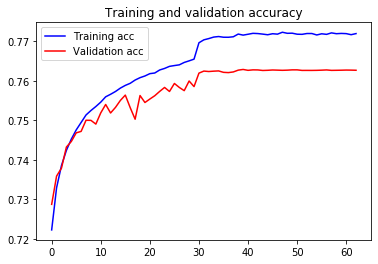

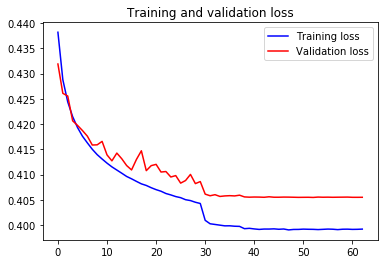

In [10]:
# Network Performances Display
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [43]:
from sklearn.metrics import classification_report

y_pred = model_final.predict(x_test, batch_size=32)



In [44]:
y_pred1 = np.around(y_pred)

In [46]:
data=pd.DataFrame(y_pred1)
data.describe()

,0
count,140394.000000
mean,0.145911
std,0.353018
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002893C078D30>]],
      dtype=object)

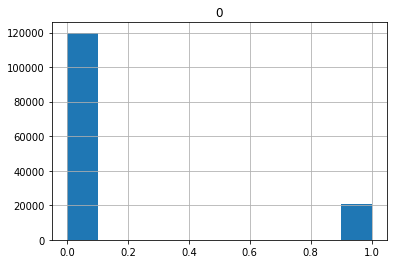

In [47]:
data.hist()

In [45]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.78      0.94      0.85     99534
           1       0.69      0.35      0.46     40860

    accuracy                           0.76    140394
   macro avg       0.73      0.64      0.65    140394
weighted avg       0.75      0.76      0.74    140394



In [26]:
model_final.save('D:/RAVDESS/TrasferLearning_model.h5')

In [36]:

y_pred1

array([[0.21804535],
       [0.17550749],
       [0.32357624],
       ...,
       [0.84727275],
       [0.33817276],
       [0.27556565]], dtype=float32)

In [31]:
data=pd.DataFrame(y_test)
data.describe()

,0
count,140394.000000
mean,0.291038
std,0.454243
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028973E44AC8>]],
      dtype=object)

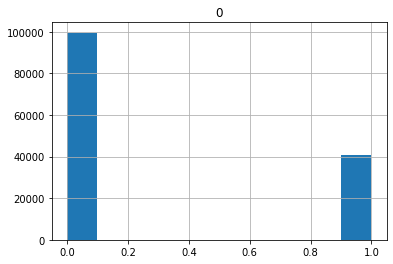

In [33]:
data.hist()

C:\Users\yobitrust\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:158: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
C:\Users\yobitrust\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:159: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
C:\Users\yobitrust\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:161: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
C:\Users\yobitrust\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:162: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
C:\Users\yobitrust\Anaconda3\envs\tf_gpu\lib

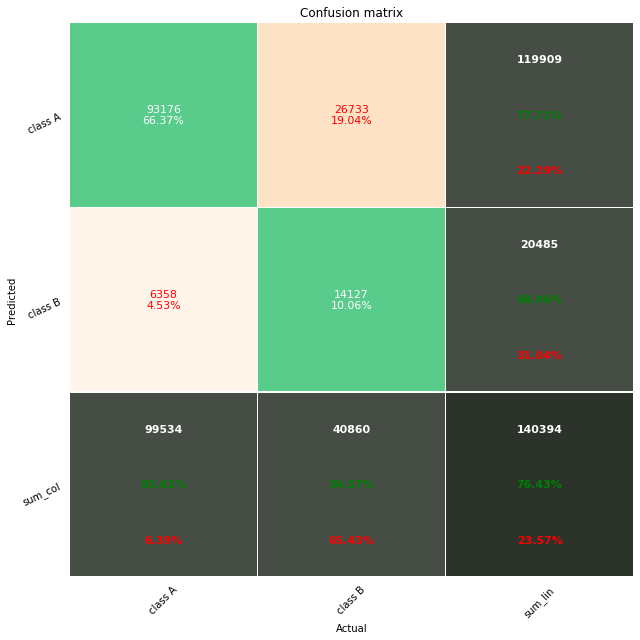

In [48]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh
import seaborn as sn

from sklearn.metrics import confusion_matrix


columns=None
annot=True
fmt='.2f'
lw=0.5
cbar=False
pred_val_axis='lin'
    
def get_new_fig(fn, figsize=[9,9]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1

def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(cell_val != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='w', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.2f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.2f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del

def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['sum_lin'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['sum_col'] = sum_col
    




def pretty_plot_confusion_matrix(df_cm, annot=True, cmap="Oranges", fmt='.2f', fz=11,
      lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='y'):
    """
      print conf matrix with default layout (like matlab)
      params:
        df_cm          dataframe (pandas) without totals
        annot          print text in each cell
        cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
        fz             fontsize
        lw             linewidth
        pred_val_axis  where to show the prediction values (x or y axis)
                        'col' or 'x': show predicted values in columns (x axis) instead lines
                        'lin' or 'y': show predicted values in lines   (y axis)
    """
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'
        df_cm = df_cm.T


    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    ax = sn.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title('Confusion matrix')
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  #set layout slim
    plt.show() 
    
    
    
#data
if(not columns):
    #labels axis integer:
    ##columns = range(1, len(np.unique(y_test))+1)
    #labels axis string:
    from string import ascii_uppercase
    columns = ['class %s' %(i) for i in list(ascii_uppercase)[0:len(np.unique(y_test))]]

confm = confusion_matrix(y_test, y_pred1)
cmap = 'Oranges';
fz = 11;
figsize=[9,9];
show_null_values = 2
df_cm = pd.DataFrame(confm, index=columns, columns=columns)
pretty_plot_confusion_matrix(df_cm, fz=fz, cmap=cmap, figsize=figsize, show_null_values=show_null_values, pred_val_axis=pred_val_axis)